## Twitter Data Analysis with Python

### First day: retrieving tweets with Tweepy

See the course appendix for how to setup your virtual environment. If you want to follow along make sure you:
- pip installed the `requirements.txt` which includes `tweepy`, `wordcloud` and related dependencies we will use in this lesson
- create your own Twitter app [here](https://apps.twitter.com/app/new), generating the required credentials/tokens 
- export these as environment variables in your `venv/bin/activate` (virtual env startup script):

        export TWITTER_KEY='abc'
        export TWITTER_SECRET='abc'
        export TWITTER_ACCESS_TOKEN='xyz'
        export TWITTER_ACCESS_SECRET='xyz'

In [15]:
from collections import namedtuple, Counter
import os
import re

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tweepy
from wordcloud import WordCloud, STOPWORDS

Tweet = namedtuple('Tweet', 'id text created likes rts')

TWITTER_ACCOUNT = 'OniwaBansho'

TWITTER_KEY = os.environ['TWITTER_KEY']
TWITTER_SECRET = os.environ['TWITTER_SECRET']
TWITTER_ACCESS_TOKEN = os.environ['TWITTER_ACCESS_TOKEN']
TWITTER_ACCESS_SECRET = os.environ['TWITTER_ACCESS_SECRET']


In this lesson we will be using [Tweepy](http://docs.tweepy.org/en/v3.5.0/api.html) and its powerful [Cursor pagination object](http://docs.tweepy.org/en/v3.5.0/cursor_tutorial.html).

We will use it to retrieve PyBites' Twitter history (~ 2.4k tweets as of Jan 2018) to:
- get most popular tweets by # likes / RTs, 
- see what the most common hashtags and mentions are, and
- create a nice [wordcloud](https://github.com/amueller/word_cloud) of our tweets.

First we need to instantiate `tweepy` and create an `api` object.

In [16]:
auth = tweepy.OAuthHandler(TWITTER_KEY, TWITTER_SECRET)
auth.set_access_token(TWITTER_ACCESS_TOKEN, TWITTER_ACCESS_SECRET)
api = tweepy.API(auth)
api

Let's define a function to get all our tweets. My first attempts left RTs and replies out but if we look at mentions it might be useful to keep them around. They are also easy to exclude later with some _list comprehensions_.

In [17]:
def get_tweets():
    for tw in tweepy.Cursor(api.user_timeline, screen_name=TWITTER_ACCOUNT,
                            exclude_replies=False, include_rts=True).items():
        yield Tweet(tw.id, tw.text, tw.created_at, tw.favorite_count, tw.retweet_count)

In [19]:
tweets = list(get_tweets())

In [20]:
len(tweets)

254

Let's look at what our most popular tweets have been so far based on a simple average of number of likes and retweets. 

In [21]:
excl_rts = [tweet for tweet in tweets if not tweet.text.startswith('RT')]
top_10 = sorted(excl_rts, key=lambda tw: (tw.likes + tw.rts)/2, reverse=True)

fmt = '{likes:<5} | {rts: <5} | {text}'
print(fmt.format(likes='❤', rts='♺', text='✎'))
print('-'*100)
for tw in top_10:
    print(fmt.format(likes=tw.likes, rts=tw.rts, text=tw.text.replace('\n', ' ⏎ ')))

❤     | ♺     | ✎
----------------------------------------------------------------------------------------------------
27    | 6     | Looking forward to restarting #100DaysOfCode on Wednesday.  Just updated to the newest PyCharm (so I can finally us… https://t.co/0xThltIaBo
27    | 2     | Day 3 of #100DaysOfCode finished a project that I had been putting off for 8 months and reduced run time from 5 hours to 30 seconds!
21    | 5     | Day 47: #100DaysOfCode progress: today I worked on Web Scraping with BeautifulSoup4 / D2 (practice)… https://t.co/OOhtAqAPdA
17    | 7     | Day 2: #100DaysOfCode progress: today I worked on Playing with Datetimes / D2 (practice).  strptime is super useful… https://t.co/nJiLM2TQ2P
18    | 4     | D45 #100DaysOfCode Still fighting #NGINX and static files with #django.  One site works other doesn't.  Everything seems setup right. GRRR 😡
18    | 2     | D22 #100DaysOfCode Took a month off because of moving :( first day back and I fight the python environme

What are our common hashtags and mentions? 

In [22]:
hashtag = re.compile(r'#[-_A-Za-z0-9]+')
mention = re.compile(r'@[-_A-Za-z0-9]+')

all_tweets = ' '.join([tw.text.lower() for tw in tweets])
all_tweets_excl_rt = ' '.join([tw.text.lower() for tw in tweets if not tw.text.startswith('RT')])

hashtags = hashtag.findall(all_tweets)
cnt = Counter(hashtags)
cnt.most_common(20)

[('#100daysofcode', 120),
 ('#python', 21),
 ('#codingame', 9),
 ('#exercism', 6),
 ('#raspberrypi', 6),
 ('#exercism_io', 5),
 ('#bgg', 3),
 ('#alexa', 3),
 ('#nginx', 3),
 ('#mtg', 2),
 ('#becausewesuitupforgameday', 2),
 ('#rejectedcandy', 2),
 ('#treesistance', 1),
 ('#slush17', 1),
 ('#100daysofcodeam', 1),
 ('#boardgame', 1),
 ('#100daysofcodefound', 1),
 ('#django', 1),
 ('#ubuntu', 1),
 ('#gencon', 1)]

❤ #Python ❤ #100DaysOfCode ❤

In [23]:
mentions = mention.findall(all_tweets)
cnt = Counter(mentions)
cnt.most_common(15)

[('@barleyhop', 41),
 ('@talkpython', 17),
 ('@pybites', 16),
 ('@luckysonofaduck', 13),
 ('@vidae01', 12),
 ('@foodbot5000', 6),
 ('@kalophoenix', 5),
 ('@pixelatedbrewco', 4),
 ('@onevoicebutmine', 3),
 ('@oniwabansho', 3),
 ('@ggogogirl', 3),
 ('@kccauldron', 2),
 ('@makebigthings', 2),
 ('@ka11away', 2),
 ('@pubhoundpressrp', 2)]

In [24]:
mentions = mention.findall(all_tweets_excl_rt)
cnt = Counter(mentions)
cnt.most_common(15)

[('@barleyhop', 40),
 ('@pybites', 16),
 ('@talkpython', 16),
 ('@luckysonofaduck', 13),
 ('@vidae01', 12),
 ('@foodbot5000', 6),
 ('@pixelatedbrewco', 4),
 ('@kalophoenix', 4),
 ('@onevoicebutmine', 3),
 ('@ggogogirl', 3),
 ('@makebigthings', 2),
 ('@oniwabansho', 2),
 ('@midnight', 2),
 ('@chuckufarley420', 2),
 ('@thestewradio', 2)]

In [25]:
# !pip install wordcloud
# just for demo: you can run shell commands with ! 
# this dependency you should already have after pip install -r requirements.txt

In [26]:
all_tweets_excl_rts_mentions = ' '.join([tw.text.lower() for tw in tweets 
                                        if not tw.text.startswith('RT') and not tw.text.startswith('@')])

Andreas Mueller's [wordcloud](https://github.com/amueller/word_cloud) is awesome, you just feed it a text (here: all our concatenated tweets) and a mask image and it creates a word cloud on top of it:

In [27]:
pb_mask = np.array(Image.open("pybites.png"))
stopwords = set(STOPWORDS)

stopwords.add('co')
stopwords.add('https')

wc = WordCloud(background_color="white", max_words=2000, mask=pb_mask,
               stopwords=stopwords)

wc.generate(all_tweets_excl_rts_mentions)

(-0.5, 2499.5, 2499.5, -0.5)

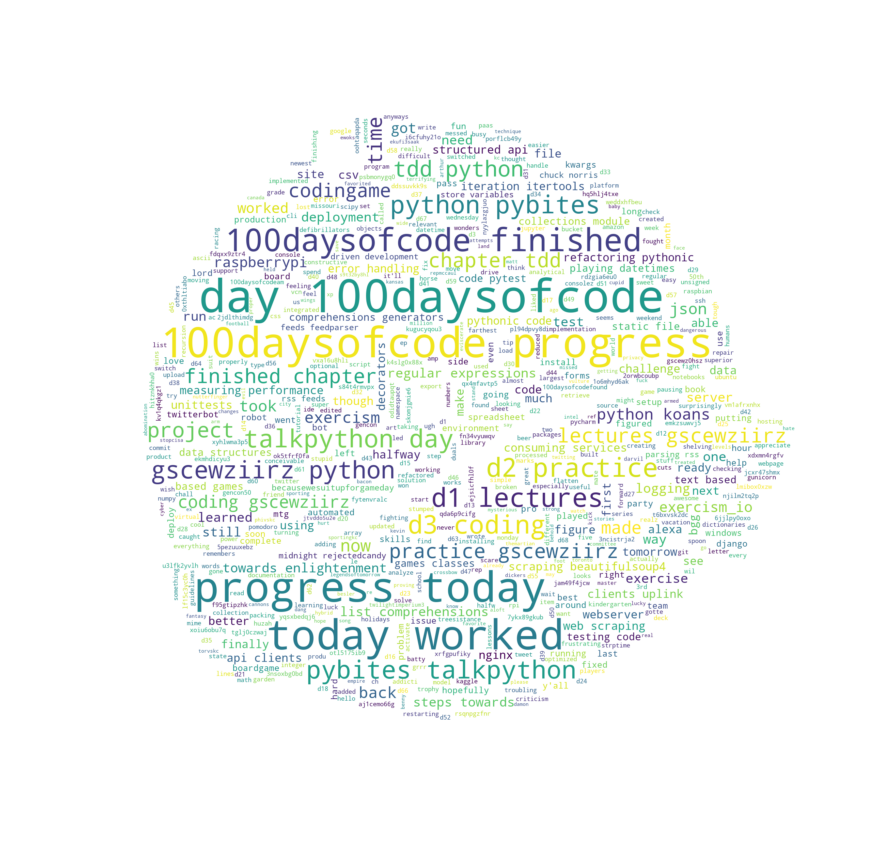

In [28]:
plt.figure(figsize=(15, 15))
plt.imshow(wc, interpolation="bilinear")
plt.margins(x=0, y=0)
plt.axis("off")

### Second and third day - practice, practice, practice:

We covered Twitter data analysis quite extensively on our blog. Below I am listing a combination of tools and challenges you can work on. As they are not small projects I bundled day 2 and 3 to focus on getting one working.

- (__PyBites preferred__)  [How we Automated our 100DaysOfCode Daily Tweet](https://pybit.es/100days-autotweet.html) - seriously: automate this task, it makes your life easier freeing you up to do more coding (it's not only the tweet, Twitter is a distraction everytime you go there ...) - the daily tweet re-enforces commitment to completing the _#100DaysOfCode_! 
    - Related article: [Automate Tweeting: how to build a Twitterbot](https://pybit.es/automate-twitter.html) - nice extension to learn how to POST to the Twitter API

- 3 part code challenge: 
    - [04 - Twitter data analysis Part 1: Getting Data](https://codechalleng.es/challenges/4/)
    - [05 - Twitter data analysis Part 2: Similar Tweeters](https://codechalleng.es/challenges/5/)
    - [07 - Twitter Sentiment Analysis](https://codechalleng.es/challenges/7/) (using a cool module called _TextBlob_)

- You like the testing part? Maybe you can try to mock Twitter API calls, see [Parsing Twitter Geo Data and Mocking API Calls by Example](https://pybit.es/twitter-api-geodata-mocking.html)

- You could also combine this effort with the [Slack API](https://api.slack.com), posting to a channel each time your domain is mentioned, see [here](https://github.com/pybites/100DaysOfCode/blob/master/020/domain_mentions.py) (a tool we still use).

- Or manually draw stats from a downloaded Twitter archive, see [here](https://github.com/pybites/100DaysOfCode/tree/master/086)

- One final option: build a small web app around Twitter data, for example: [Building a Simple Web App With Bottle, SQLAlchemy, and the Twitter API](https://realpython.com/blog/python/building-a-simple-web-app-with-bottle-sqlalchemy-twitter-api/) (here I learned about _Cursor_ as efficient/fast way to retrieve Twitter data). 

- Another Twitter data related project ...

Have fun and remember, keep calm and code in Python!